In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [24]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten


In [33]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LSTM, TimeDistributed
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.optimizers import Adam

# Define paths
base_path = '/kaggle/input/assignment'
train1_csv = os.path.join(base_path, 'DATA SCIENTIST_ASSIGNMENT/Licplatesdetection_train.csv')
train2_csv = os.path.join(base_path, 'DATA SCIENTIST_ASSIGNMENT/Licplatesrecognition_train.csv')
train1_images_path = os.path.join(base_path, 'DATA SCIENTIST_ASSIGNMENT/Licplatesdetection_train/license_plates_detection_train')
train2_images_path = os.path.join(base_path, 'DATA SCIENTIST_ASSIGNMENT/Licplatesrecognition_train/license_plates_recognition_train')
test_images_path = os.path.join(base_path, 'DATA SCIENTIST_ASSIGNMENT/test/test/test')



In [32]:
annotations_train1 = pd.read_csv(train1_csv)
annotations_train2 = pd.read_csv(train2_csv)

print("Training Set 1 Annotations:")
print(annotations_train1.head())

print("Training Set 2 Annotations:")
print(annotations_train2.head())


Training Set 1 Annotations:
    img_id  ymin  xmin  ymax  xmax
0    1.jpg   276    94   326   169
1   10.jpg   311   395   344   444
2  100.jpg   406   263   450   434
3  101.jpg   283   363   315   494
4  102.jpg   139    42   280   222
Training Set 2 Annotations:
    img_id      text
0    0.jpg  117T3989
1    1.jpg  128T8086
2   10.jpg   94T3458
3  100.jpg  133T6719
4  101.jpg   68T5979


In [36]:
def visualize_annotations(image_path, bbox):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file not found: {image_path}")

    image = cv2.imread(image_path)
    if image is None:
        raise IOError(f"Failed to read image: {image_path}")

    ymin, xmin, ymax, xmax = bbox
    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()




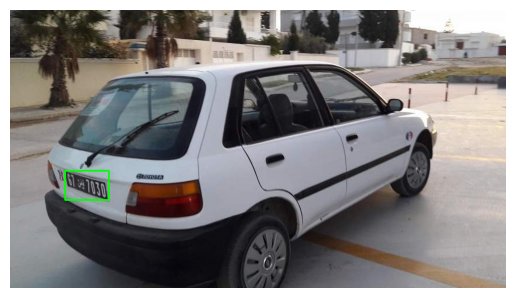

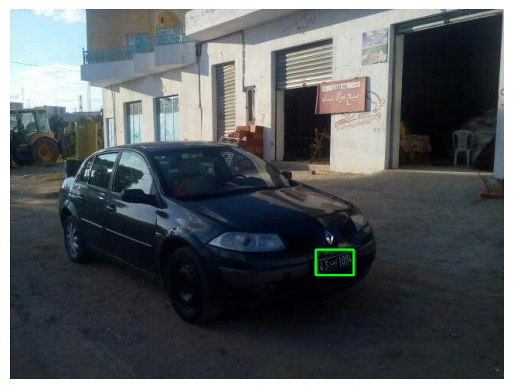

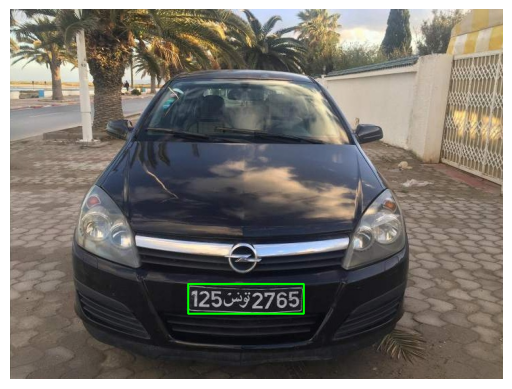

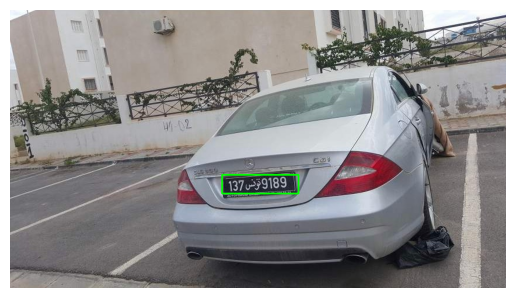

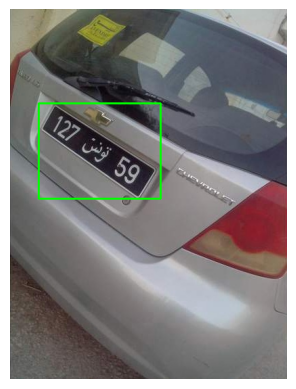

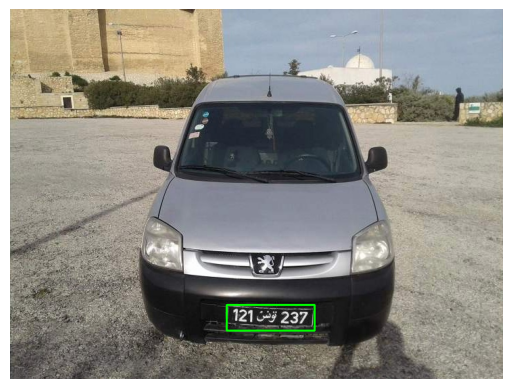

In [38]:
# Visualize a few images from Training Set 1
for idx, row in annotations_train1.iterrows():
    image_path = os.path.join(train1_images_path, row["img_id"])
    bbox = row[['ymin', 'xmin', 'ymax', 'xmax']].values
    visualize_annotations(image_path, bbox)
    if idx == 5:
        break

def visualize_license_plate(image_path, label):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file not found: {image_path}")

    image = cv2.imread(image_path)
    if image is None:
        raise IOError(f"Failed to read image: {image_path}")

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(label)
    plt.axis('off')
    plt.show()



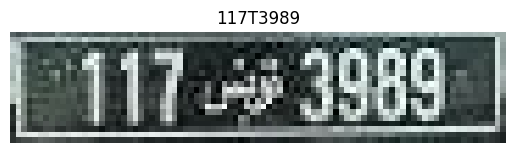

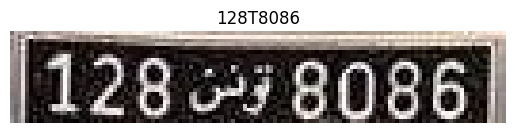

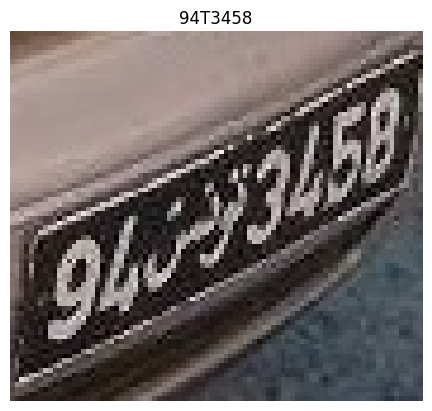

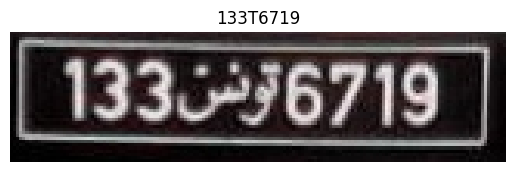

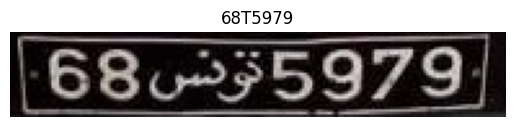

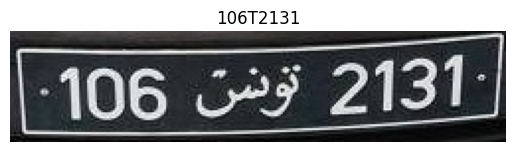

In [39]:
# Visualize a few images from Training Set 2
for idx, row in annotations_train2.iterrows():
    image_path = os.path.join(train2_images_path, row["img_id"])
    label = row["text"]
    visualize_license_plate(image_path, label)
    if idx == 5:
        break

In [40]:
def preprocess_image(image_path, target_size=(224, 224)):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    image = image.astype('float32') / 255.0
    return image

def preprocess_image_for_recognition(image_path, target_size=(128, 64)):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    image = image.astype('float32') / 255.0
    return image



In [41]:
# Example: Preprocess an image
image_path = os.path.join(train1_images_path, annotations_train1.iloc[0]["img_id"])
preprocessed_image = preprocess_image(image_path)
print(preprocessed_image.shape)

# Encode labels
def encode_label(label, max_length=10):
    label = label.ljust(max_length)
    label_encoded = [ord(c) for c in label]
    return label_encoded

# Example: Preprocess an image and its label
image_path = os.path.join(train2_images_path, annotations_train2.iloc[0]["img_id"])
preprocessed_image = preprocess_image_for_recognition(image_path)
label = annotations_train2.iloc[0]["text"]
preprocessed_label = encode_label(label)
print(preprocessed_image.shape, preprocessed_label)


(224, 224, 3)
(128, 64, 3) [49, 49, 55, 84, 51, 57, 56, 57, 32, 32]


Bounding Box Size Statistics:
count      900.000000
mean      5899.225556
std       3926.991379
min        871.000000
25%       3305.500000
50%       4990.000000
75%       7512.750000
max      40698.000000
dtype: float64


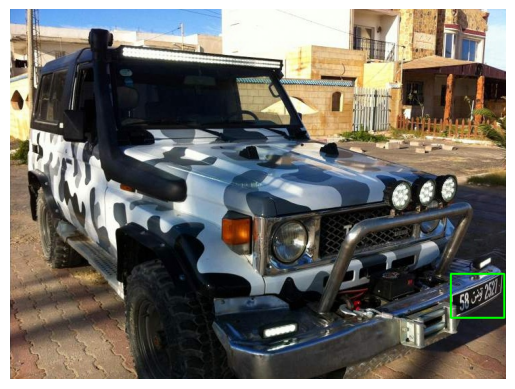

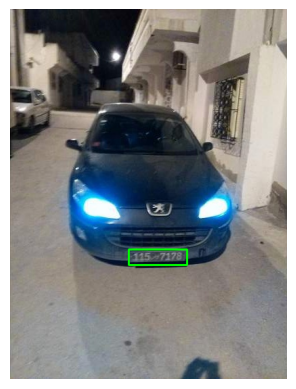

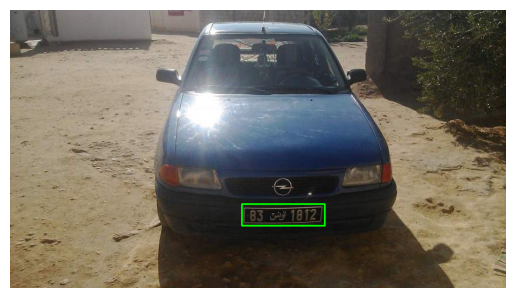

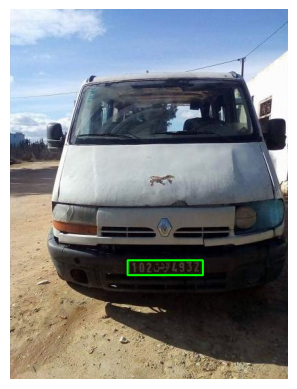

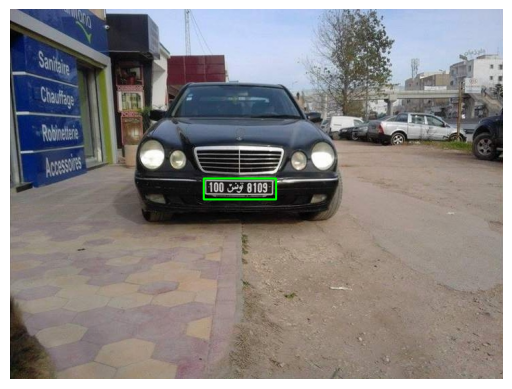

In [28]:
# Calculate statistics of bounding box sizes
bbox_sizes = annotations_train1.apply(lambda row: (row['ymax'] - row['ymin']) * (row['xmax'] - row['xmin']), axis=1)
print("Bounding Box Size Statistics:")
print(bbox_sizes.describe())

import random

sample_images = annotations_train1.sample(5)  # Sample 5 random images
for idx, row in sample_images.iterrows():
    image_path = os.path.join(train1_images_path, row["img_id"])
    bbox = row[['ymin', 'xmin', 'ymax', 'xmax']].values
    visualize_annotations(image_path, bbox)


In [77]:
# Define and compile a simple CNN model for license plate detection
detection_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(4)  # Output layer for bounding box coordinates
])

detection_model.compile(optimizer='adam',
                        loss='mse',  # Mean Squared Error for bounding box regression
                        metrics=['accuracy'])

detection_model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 64)             │    11,944,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,963,652 (45.64 MB)

 Trainable params: 11,963,652 (45.64 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
from tensorflow.keras.layers import Bidirectional, BatchNormalization

def build_crnn_model(input_shape=(128, 64, 3), num_classes=36):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        TimeDistributed(Flatten()),
        Bidirectional(LSTM(128, return_sequences=True)),
        Dense(num_classes, activation='softmax')
    ])
    return model

recognition_model = build_crnn_model()
recognition_model.compile(optimizer=Adam(), loss='ctc_loss')  # Placeholder for CTC loss

recognition_model.summary()


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 126, 62, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 63, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 61, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 30, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 30, 896)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 30, 256)        │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 30, 36)         │         9,252 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,078,244 (4.11 MB)

 Trainable params: 1,078,244 (4.11 MB)

 Non-trainable params: 0 (0.00 B)

In [66]:
from sklearn.model_selection import train_test_split

# Split data into training and validation sets for detection model
vehicle_images_train, vehicle_images_val, bbox_train, bbox_val = train_test_split(
    annotations_train1["img_id"].values, 
    annotations_train1[['ymin', 'xmin', 'ymax', 'xmax']].values, 
    test_size=0.2
)








In [42]:
# Train detection model
detection_model.fit(detection_data_generator(vehicle_images_train, bbox_train),
                    steps_per_epoch=len(vehicle_images_train) // 32,
                    validation_data=detection_data_generator(vehicle_images_val, bbox_val),
                    validation_steps=len(vehicle_images_val) // 32,
                    epochs=10)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.6910 - loss: 8481.8418 - val_accuracy: 0.6500 - val_loss: 8318.6475
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.7367 - loss: 7706.0312 - val_accuracy: 0.6824 - val_loss: 8478.4902
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.7393 - loss: 7032.1597 - val_accuracy: 0.6622 - val_loss: 9181.6982
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.7729 - loss: 6188.7412 - val_accuracy: 0.7095 - val_loss: 7780.3667
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.7841 - loss: 5859.7681 - val_accuracy: 0.7027 - val_loss: 6825.9395
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.7833 - loss: 5534.4370 - val_accuracy: 0.6892 - val_loss: 7430.7456
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.8138 - loss: 5000.0967 - val_accuracy: 0.7312 - val_loss: 7797.6533
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.8294 - loss:

In [78]:
# Data generator for detection model
def detection_data_generator(image_paths, bboxes, batch_size=32):
    while True:
        for start in range(0, len(image_paths), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(image_paths))
            i_batch = image_paths[start:end]
            b_batch = bboxes[start:end]
            for i, b in zip(i_batch, b_batch):
                img_path = os.path.join(train1_images_path, i)
                image = preprocess_image(img_path)
                x_batch.append(image)
                y_batch.append(b)
            yield np.array(x_batch), np.array(y_batch)

In [83]:
# Split data into training and validation sets for recognition model
plate_images_train, plate_images_val, text_train, text_val = train_test_split(
    annotations_train2["img_id"].values, 
    annotations_train2["text"].values, 
    test_size=0.2
)

# Data generator for recognition model
def recognition_data_generator(image_paths, texts, batch_size=32):
    while True:
        for start in range(0, len(image_paths), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(image_paths))
            i_batch = image_paths[start:end]
            t_batch = texts[start:end]
            for i, t in zip(i_batch, t_batch):
                img_path = os.path.join(train2_images_path, i)
                image = preprocess_image_for_recognition(img_path)
                label = encode_label(t)
                x


error: OpenCV(4.10.0) /io/opencv/modules/dnn/src/darknet/darknet_importer.cpp:210: error: (-212:Parsing error) Failed to open NetParameter file: yolov3.cfg in function 'readNetFromDarknet'
